## Предсказание целевого показателя в системе налогообложения

Задача:
 - Задача: по 11 признакам, связанным с информациями об организациях в системе налогообложения (из обучающей выборки train), предсказать, продлится пользователь (из тестовой выборки test) или нет. Надо предсказать целевой показатель: is_prolong из train.

Описание:
 - id	идентификатор
 - taxactionSystem	 система налогообложения
 - regdt  Дата регистрации
 - workerCount   количество сотрудников
 - fssdccount   количество отправленных отчетов в ФСС из этой организации из БК за все время существования.
 - pfrdcCount   количество отправленных отчетов в ПФР из этой организации из БК за все время существования.
 - fnsdcCount   количество отправленных отчетов в ФНС из этой организации из БК за все время существования.
 - hasCloudCryptCertificate   был ли когда-либо в этой организации выпущен облачный сертификат
 - OrgCreationDate  дата добавления организации в БК Это не дата регистрации организации в ФНС и т.д., это дата, когда  -  -  организация была добавлена (создана) в БК
 - documentsCount  количество документов. Считает количество документов в системе (которые показываются на вкладке ""Все"") в этом количестве учитываются не все документы )
 - cnt_users   количество пользователей

Формат файла ответов:
 - id, is_prolong

### Библиотеки

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import cross_validation, metrics, naive_bayes, linear_model, svm, tree, ensemble 
from dateutil.parser import parse
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Загрузка данных

In [2]:
X_test = pd.read_csv('test.csv',)
X_test.columns = X_test.columns.str.strip() #удаление пробелов 
X_train = pd.read_csv('train.csv')
X_train.columns = X_train.columns.str.strip()

### Структура данных датасета X_train и X_test
 - размеры
 - проверка пропущенных значений 
 - типы признаков

In [3]:
print('Shape : ' + str(X_train.shape))
print('Isnull : ' +str(X_train.isnull().values.any()))
print(X_train.info())
X_train.head()

Shape : (7626, 12)
Isnull : False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7626 entries, 0 to 7625
Data columns (total 12 columns):
id                          7626 non-null int64
taxactionSystem             7626 non-null object
regdt                       7626 non-null object
workerCount                 7626 non-null float64
fssdccount                  7626 non-null float64
pfrdcCount                  7626 non-null float64
fnsdcCount                  7626 non-null float64
hasCloudCryptCertificate    7626 non-null int64
OrgCreationDate             7626 non-null object
documentsCount              7626 non-null float64
cnt_users                   7626 non-null float64
is_prolong                  7626 non-null float64
dtypes: float64(7), int64(2), object(3)
memory usage: 715.0+ KB
None


,id,taxactionSystem,regdt,workerCount,fssdccount,pfrdcCount,fnsdcCount,hasCloudCryptCertificate,OrgCreationDate,documentsCount,cnt_users,is_prolong
0,101969,УСН Доходы 6%,1994-03-26,5.0,0.0,0.0,0.0,0,04.12.2014,2.0,0.0,1.0
1,108477,ОСНО,2012-12-05,1.0,0.0,0.0,0.0,0,22.09.2014,5.0,0.0,0.0
2,101476,УСН Доходы 6%,2009-11-15,1.0,3.0,3.0,2.0,0,05.04.2016,0.0,0.0,1.0
3,102579,УСН Доходы за вычетом расходов 15%,2015-08-09,1.0,0.0,0.0,0.0,0,24.09.2015,0.0,0.0,0.0
4,103110,УСН Доходы за вычетом расходов 15%,2015-03-29,0.0,0.0,0.0,0.0,0,03.04.2015,4.0,0.0,0.0


In [4]:
print('Shape : ' + str(X_test.shape))
print('Isnull : ' +str(X_test.isnull().values.any()))
print(X_test.info())
X_test.head()

Shape : (2542, 11)
Isnull : False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 11 columns):
id                          2542 non-null int64
taxactionSystem             2542 non-null object
regdt                       2542 non-null object
workerCount                 2542 non-null float64
fssdccount                  2542 non-null float64
pfrdcCount                  2542 non-null float64
fnsdcCount                  2542 non-null float64
hasCloudCryptCertificate    2542 non-null int64
OrgCreationDate             2542 non-null object
documentsCount              2542 non-null float64
cnt_users                   2542 non-null float64
dtypes: float64(6), int64(2), object(3)
memory usage: 218.5+ KB
None


,id,taxactionSystem,regdt,workerCount,fssdccount,pfrdcCount,fnsdcCount,hasCloudCryptCertificate,OrgCreationDate,documentsCount,cnt_users
0,106879,ОСНО,2014-11-01,0.0,1.0,0.0,2.0,1,31.03.2015,5.0,1.0
1,108820,УСН Доходы за вычетом расходов 6%,2012-02-25,2.0,1.0,2.0,1.0,1,15.01.2015,5.0,0.0
2,104079,УСН Доходы за вычетом расходов 15%,2014-06-09,0.0,1.0,1.0,2.0,0,15.05.2014,6.0,1.0
3,106924,УСН Доходы за вычетом расходов 15%,2011-09-11,1.0,0.0,0.0,0.0,0,04.09.2014,5.0,0.0
4,106335,УСН Доходы за вычетом расходов 5%,2005-06-04,3.0,2.0,2.0,2.0,0,04.03.2016,7.0,0.0


Как видно, NaNы в данных отсутствуют. Кроме числовых типов, имеются 3 объекта: taxactionSystem, regdt и OrgCreationDate. taxactionSystem - строки, regdt и OrgCreationDate - даты.

### Предобработка данных

 - Текстовый признак taxactionSystem будем кодировать числовым по количеству слов. Из regdt и OrgCreationDate выделим год, месяц и день. Добавим все в виде новых числовых признаков. Позже удалим исходные.
 - Для корректной кодировки необходимо объединить обучающую и тестовую выборки. Добавим новый столбец is_prolong в X_test из нулей для совпадения числа столбцов. Первое значение сделаем =2 для идентицикации начала тестовой выборки (на всякий случай).

In [5]:
X_test['is_prolong']=np.zeros(X_test.shape[0])
X_test.is_prolong[0]=2;
X = pd.concat([X_train,X_test],axis=0)
X.reset_index(drop=True, inplace=True)
print('Shape of X_train: ' + str(X_train.shape))
print('Shape of X_test: ' + str(X_test.shape))
print('Shape of X: ' + str(X.shape))

Shape of X_train: (7626, 12)
Shape of X_test: (2542, 12)
Shape of X: (10168, 12)


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


 - Проверим данные regdt и OrgCreationDate на пустые значения, а также возможность выделить год. Построим гистограммы.

empty_reg = 27
empty_org = 0


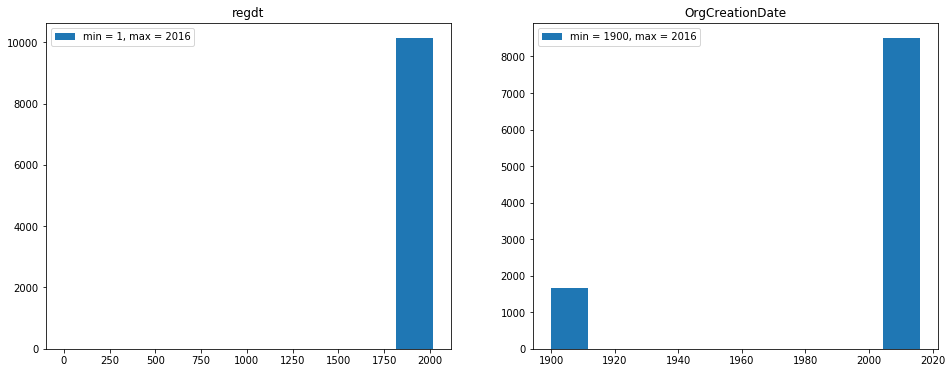

In [6]:
year_check1=[];
year_check2=[];
empty_reg=0;
empty_org=0;
for i in range(X.shape[0]):
    
    if X.regdt[i].strip():
        year_check1.append(parse(X.regdt[i]).year)
    else:
        empty_reg = empty_reg+1
        
    if X.OrgCreationDate[i].strip(): 
        year_check2.append(parse(X.OrgCreationDate[i]).year)
    else:
        empty_org = empty_org+1
print('empty_reg = ' + str(empty_reg))
print('empty_org = ' + str(empty_org))
plt.figure(figsize=(16,6));    
plt.subplot(1,2,1);
plt.hist(year_check1,label='min = ' + str(np.min(year_check1))+ ', max = ' + str(np.max(year_check1)));
plt.title('regdt');
plt.legend();
plt.subplot(1,2,2);
plt.hist(year_check2,label='min = ' + str(np.min(year_check2))+ ', max = ' + str(np.max(year_check2)));
plt.title('OrgCreationDate');
plt.legend();

(1750, 2020)

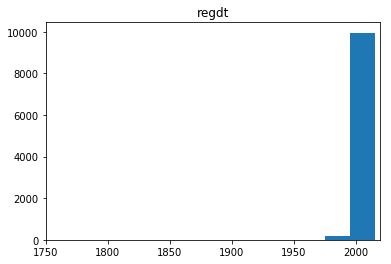

In [7]:
plt.hist(year_check1,bins=100);
plt.title('regdt');
plt.xlim([1750, 2020])

 - Как видно в данных присутствуют как пустые (empty_reg = 27), так и некорректные значения (1 для regdt и 1900 для  OrgCreationDate). Так как варианты с осреднением или обнулением даты не подойдут, то очевидным решением будет исключение таких данных. Сделаем это:

In [8]:
def time_filter_index(feature_sample,year_min):
    indx=[];
    for i in range(feature_sample.shape[0]):
        if feature_sample[i].strip():
            if int(parse(feature_sample[i]).year) < year_min:
                indx.append(i)
        else:
            indx.append(i)
    return indx       

In [9]:
indx = time_filter_index(X.regdt,1950)
print('Shape before filtration: ' + str(X.shape))      
X_regf = X.drop(X.index[indx])
X_regf.reset_index(drop=True, inplace=True)
print('Shape after filtration: ' + str(X_regf.shape))

Shape before filtration: (10168, 12)
Shape after filtration: (10134, 12)


In [10]:
indx = time_filter_index(X_regf.OrgCreationDate,1950)
print('Shape before filtration: ' + str(X_regf.shape))      
X_regorgf = X_regf.drop(X_regf.index[indx]) 
X_regorgf.reset_index(drop=True, inplace=True)
print('Shape after filtration: ' + str(X_regorgf.shape)) 

Shape before filtration: (10134, 12)
Shape after filtration: (8474, 12)


 - теперь представим столбцы с датами в виде новых столбцов: год, месяц, день. Удалим исходные:

In [11]:
def time_vec(X,feature_sample):
    X[feature_sample] = X[feature_sample].apply(pd.to_datetime);
    X[feature_sample + '_year'] = X[feature_sample].apply(lambda x: x.year);
    X[feature_sample + '_month'] = X[feature_sample].apply(lambda x: x.month);
    X[feature_sample + '_day'] = X[feature_sample].apply(lambda x: x.day);
    X = X.drop(feature_sample,axis=1)
    return X

In [12]:
X_regorgf_vec = time_vec(X_regorgf,'regdt')
X_regorgf_vec = time_vec(X_regorgf_vec,'OrgCreationDate')

 - кодируем признак taxactionSystem:

In [13]:
def vectorize_str(feature_sample):
    vec = CountVectorizer()
    xv = vec.fit_transform(feature_sample)    
    feature_sample_vec = pd.DataFrame(xv.toarray(),columns = vec.get_feature_names())
    return feature_sample_vec

In [14]:
tax_vec = vectorize_str(X_regorgf_vec.taxactionSystem)
print('УСН:     ' + str(np.sum(tax_vec.усн)))
print('доходы:  ' + str(np.sum(tax_vec.доходы)))
print('за:      ' + str(np.sum(tax_vec.за)))
print('вычетом: ' + str(np.sum(tax_vec.вычетом)))
print('расходов:' + str(np.sum(tax_vec.расходов)))

УСН:     4689
доходы:  4689
за:      2125
вычетом: 2125
расходов:2125


 - Слова "УСН" и "доходы" встречаются в тексте только вместе, так же как и слова "за", "вычетом", "расходов". Избавимся от некоторых оставив только уникальные:

In [15]:
tax_vec = tax_vec.drop(['доходы','за','вычетом'],axis=1)

 - добавим вконец выборки кодированные данные, удалив исходные:

In [16]:
X_regorgf_vec_tax_vec = pd.concat([X_regorgf_vec,tax_vec],axis=1)
X_regorgf_vec_tax_vec = X_regorgf_vec_tax_vec.drop('taxactionSystem',axis=1);

 - переименуем предобработанные данные: 

In [17]:
X = X_regorgf_vec_tax_vec

 - Разделим обратно выборку на обучающую и тестовую по границе, где is_prolong=2:

In [18]:
X_train = X[:X[X.is_prolong==2].index[0]]
X_test = X[X[X.is_prolong==2].index[0]:]
print('Shape of X_train: ' + str(X_train.shape))
print('Shape of X_test: ' + str(X_test.shape))
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

Shape of X_train: (6340, 23)
Shape of X_test: (2134, 23)


 - Перемешаем обучающую выборку:

In [19]:
from sklearn.utils import shuffle
X_train = shuffle(X_train, random_state=123)

 - Отделим столбец ID, а метки is_prolong запишем в y_train для обучающей выборки. Для тестовой также отделим столбец ID и удалим заполненные ранее нулями is_prolong:

In [20]:
ID_train = X_train.id
ID_test = X_test.id
y_train = X_train.is_prolong
X_train = X_train.drop(['id','is_prolong'],axis=1)
X_test = X_test.drop(['id','is_prolong'],axis=1)
print('Shape of X_train: ' + str(X_train.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of X_test: ' + str(X_test.shape))

Shape of X_train: (6340, 21)
Shape of y_train: (6340,)
Shape of X_test: (2134, 21)


### Корреляции в данных

 - оценим уровень линейной зависимости между признаками и целевой переменной корреляцией Пирсона:

workerCount                 0.282212
fssdccount                  0.400511
pfrdcCount                  0.358827
fnsdcCount                  0.401182
hasCloudCryptCertificate    0.413299
documentsCount              0.396952
cnt_users                   0.154405
regdt_year                 -0.128621
regdt_month                -0.012211
regdt_day                  -0.001637
OrgCreationDate_year        0.166993
OrgCreationDate_month      -0.066271
OrgCreationDate_day        -0.023688
10                          0.008051
12                          0.004173
13                         -0.015837
15                          0.005211
енвд                        0.046687
осно                       -0.102109
расходов                    0.030987
усн                         0.077148
dtype: float64


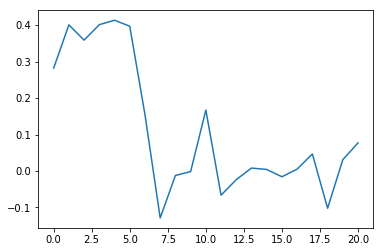

In [21]:
plt.plot(range(len(X_train.corrwith(y_train))),X_train.corrwith(y_train));
print(X_train.corrwith(y_train))

 - В целом корреляция не сильная. Максимальная корреляция признаков с метками достигает 0.4. Также посчитаем корреляции между вещественными признаками:

In [22]:
X_train.corr()

,workerCount,fssdccount,pfrdcCount,fnsdcCount,hasCloudCryptCertificate,documentsCount,cnt_users,regdt_year,regdt_month,regdt_day,...,OrgCreationDate_month,OrgCreationDate_day,10,12,13,15,енвд,осно,расходов,усн
workerCount,1.000000,0.250899,0.300031,0.104250,-0.018313,0.254752,0.076771,-0.313036,-0.051058,-0.026454,...,-0.079260,-0.021363,0.037797,0.037395,0.002563,0.052674,0.190070,-0.164085,0.089321,0.067469
fssdccount,0.250899,1.000000,0.780602,0.742483,0.452493,0.353639,0.185321,-0.086437,-0.021992,-0.003561,...,-0.078681,-0.046279,0.000191,0.018262,-0.012869,0.042681,0.011505,-0.047709,0.064466,0.041760
pfrdcCount,0.300031,0.780602,1.000000,0.651791,0.381930,0.321979,0.156138,-0.147571,-0.025601,-0.015111,...,-0.088212,-0.025191,0.002174,0.024961,-0.011427,0.041427,0.068476,-0.117206,0.077022,0.083194
fnsdcCount,0.104250,0.742483,0.651791,1.000000,0.564082,0.389442,0.197000,-0.037571,0.003128,-0.002039,...,-0.043067,-0.032015,-0.028980,0.001062,-0.015041,-0.087085,0.011842,0.193214,-0.081389,-0.181214
hasCloudCryptCertificate,-0.018313,0.452493,0.381930,0.564082,1.000000,0.291966,0.160930,0.072554,0.004064,-0.008354,...,-0.043132,0.024912,-0.031746,0.008701,-0.014565,0.003495,-0.051270,-0.004642,0.014128,0.040881
documentsCount,0.254752,0.353639,0.321979,0.389442,0.291966,1.000000,0.248045,0.024097,-0.014604,0.002098,...,-0.066929,-0.011538,0.043085,0.026478,0.004057,0.053851,-0.054922,-0.062537,0.104700,0.100042
cnt_users,0.076771,0.185321,0.156138,0.197000,0.160930,0.248045,1.000000,0.013677,0.014111,0.008885,...,-0.036324,-0.001940,0.020698,-0.008736,-0.007040,0.007998,-0.065128,0.024333,0.026323,0.008805
regdt_year,-0.313036,-0.086437,-0.147571,-0.037571,0.072554,0.024097,0.013677,1.000000,0.000742,0.022557,...,0.083585,0.039861,-0.007811,-0.007833,0.002740,-0.002042,-0.185761,0.133926,-0.006595,-0.036999
regdt_month,-0.051058,-0.021992,-0.025601,0.003128,0.004064,-0.014604,0.014111,0.000742,1.000000,0.057590,...,0.083590,0.015666,-0.007323,0.007800,0.015635,0.028817,-0.040684,0.011154,0.020043,0.000756
regdt_day,-0.026454,-0.003561,-0.015111,-0.002039,-0.008354,0.002098,0.008885,0.022557,0.057590,1.000000,...,0.007021,-0.011910,-0.019332,-0.005195,0.003344,0.004266,-0.019240,0.008205,-0.008109,-0.001704


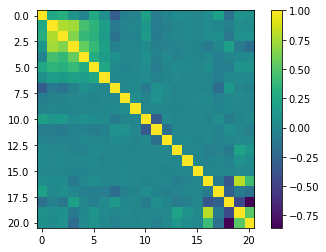

In [23]:
plt.imshow(X_train.corr());
plt.colorbar();

 - В матрице имеются несколько пар коррелирующих столбцов fssdccount, pfrdcCount, fnsdcCount и енвд, расходов. Посмотрим как этот факт сказывается на обучении линейной модели. Обучим линейную регрессию на данных и посмотрим на веса признаков:

In [24]:
linear_regressor = linear_model.LinearRegression()
linear_regressor.fit(X_train, y_train)
for w, coef in zip(X_train.columns, linear_regressor.coef_):
    print('{}: {}'.format(w, coef))

workerCount: 0.07858667062576577
fssdccount: 0.04861214912361487
pfrdcCount: -0.015925289678270556
fnsdcCount: 0.05768098794227507
hasCloudCryptCertificate: 0.25562050932147323
documentsCount: 0.037441379207969
cnt_users: 0.015454257474190172
regdt_year: -0.007272073264689788
regdt_month: -0.00011495294005653411
regdt_day: 0.0003424628652593936
OrgCreationDate_year: 0.05557016353856509
OrgCreationDate_month: 0.0027464118281825822
OrgCreationDate_day: -0.0007744112040940845
10: 0.000949875654226876
12: -0.10481255919923751
13: -0.43573522741182286
15: -0.020961001345214066
енвд: -0.041788654944838216
осно: -0.14024712140498108
расходов: -0.029392328826029077
усн: -0.04893011963212866


 - веса при линейно-зависимых признаках не сильно выделяются на фоне весов при других признаках.

### Масштаб признаков

 - посмотрим средние признаков, чтобы оценить масштаб признаков:

In [25]:
X_train.mean(axis=0)

workerCount                    0.800631
fssdccount                     0.835331
pfrdcCount                     0.840221
fnsdcCount                     1.230599
hasCloudCryptCertificate       0.573502
documentsCount                 4.125394
cnt_users                      0.276656
regdt_year                  2010.870820
regdt_month                    6.723659
regdt_day                     15.661199
OrgCreationDate_year        2014.790536
OrgCreationDate_month          5.823344
OrgCreationDate_day           15.988959
10                             0.016404
12                             0.003155
13                             0.000158
15                             0.179811
енвд                           0.113880
осно                           0.372397
расходов                       0.252681
усн                            0.552050
dtype: float64

 - Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки:

In [26]:
from sklearn.preprocessing import scale
X_train = scale(X_train)
X_test = scale(X_test)

### Оценка по кросс-валидации

Будем выбирать лучший классификатор по качеству по кросс-валидации.

#### Гауссов наивный байесовский классификатор:

In [27]:
gnb = naive_bayes.GaussianNB()
scores = cross_validation.cross_val_score(gnb, X_train,y_train, cv=10)
print('Качество на разбиениях:' + str(scores))
print('Среднее:' + str(scores.mean()))

Качество на разбиениях:[0.7480315  0.61417323 0.61356467 0.61198738 0.61356467 0.61356467
 0.61356467 0.61356467 0.61453397 0.61453397]
Среднее:0.6271083380451231


#### Стохастический градиентный спуск:

In [28]:
sgd = linear_model.SGDClassifier()
scores = cross_validation.cross_val_score(sgd, X_train,y_train, cv=10)
print(scores)
print(scores.mean())

[0.57322835 0.62992126 0.70820189 0.73974763 0.75394322 0.64037855
 0.72397476 0.69242902 0.7314376  0.68246445]
0.6875726738876046


C:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\stoc

#### Логистическая регрессия

In [29]:
log_regressor = linear_model.LogisticRegression(random_state = 1)
scores = cross_validation.cross_val_score(log_regressor, X_train,y_train, cv=10)
print(scores)
print(scores.mean())

[0.76692913 0.79212598 0.79495268 0.77444795 0.79495268 0.7555205
 0.76656151 0.79179811 0.75039494 0.78988942]
0.7777572916785613


#### Метод опорных векторов

In [30]:
svc=svm.SVC(C=50,gamma=0.005,kernel='rbf')
scores = cross_validation.cross_val_score(svc, X_train,y_train, cv=10)
print(scores)
print(scores.mean())

[0.7984252  0.81889764 0.8170347  0.79022082 0.79810726 0.7807571
 0.80599369 0.82176656 0.78988942 0.80410742]
0.8025199801270972


#### Деревья принятия решений

In [31]:
sqrt2_d_tree = tree.DecisionTreeClassifier(random_state=37,max_features=int(np.sqrt(X_train.shape[1])))
sqrt2_bagging = ensemble.BaggingClassifier(base_estimator=sqrt2_d_tree, random_state=11, n_estimators=300)
scores = cross_validation.cross_val_score(sqrt2_bagging, X_train,y_train, cv=10)
print(scores)
print(scores.mean())

[0.81417323 0.82204724 0.82807571 0.82807571 0.82807571 0.8044164
 0.829653   0.83596215 0.81674566 0.82464455]
0.8231869352891057


 - Из рассмотренных методов, DecisionTreeClassifier показал лучшее качество. Данный классификатор - бэггинг на рандомизированных деревьях (в которых при построении каждой вершины выбирается случайное подмножество признаков и разбиение ищется только по ним).

### Confusion_matrix

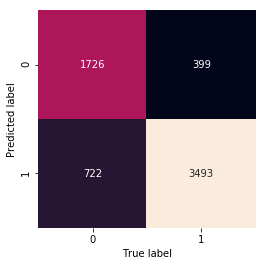

In [32]:
from sklearn.metrics import confusion_matrix
y_pred = cross_validation.cross_val_predict(sqrt2_bagging, X_train,y_train, cv=10)
conf_mat = confusion_matrix(y_train, y_pred)
sns.heatmap(conf_mat.T,square=True,annot=True,fmt='d',cbar=False);
plt.xlabel('True label');
plt.ylabel('Predicted label');

### Предсказание

- Предскажем теперь метки для X_test:

In [33]:
sqrt2_bagging.fit(X_train,y_train)
#Вероятность продления
ypred_prob = sqrt2_bagging.predict_proba(X_test)
#Итоговые метки
ypred = sqrt2_bagging.predict(X_test)

- Представим результаты в виде гистограмм вероятностей продления и полученных меток:

Number of is_prolong = 1 : 1449.0
Number of is_prolong = 0 : 685.0


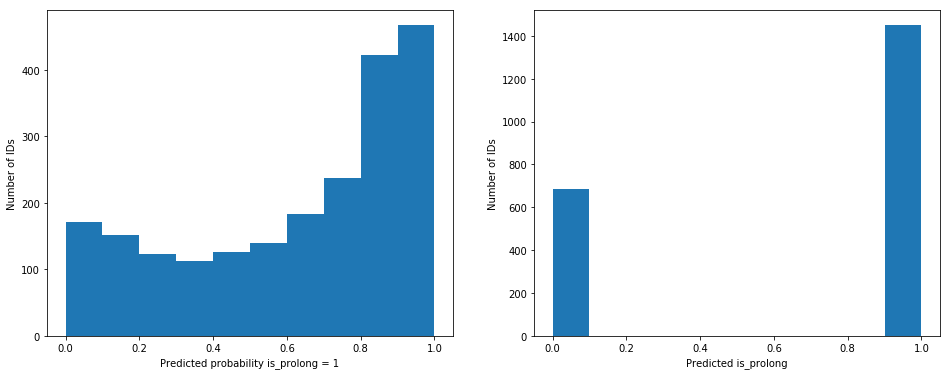

In [34]:
print('Number of is_prolong = 1 : ' + str(np.sum(ypred[ypred==1])))
print('Number of is_prolong = 0 : ' + str(ypred.shape[0]-np.sum(ypred[ypred==1])))
plt.figure(figsize=(16,6));    
plt.subplot(1,2,1);
plt.hist(ypred_prob[:,1]);
plt.xlabel('Predicted probability is_prolong = 1');
plt.ylabel('Number of IDs');
plt.subplot(1,2,2);
plt.hist(ypred);
plt.xlabel('Predicted is_prolong');
plt.ylabel('Number of IDs');

Кол-во пользователей, которые продлят 1449. Не продлят 685. 

#### Результаты в формате id, is_prolong в файле 'results.txt'

In [35]:
with open('results.txt','w') as file_obj:
    for i in range(ypred.shape[0]):
        file_obj.writelines(str(ID_test[i]) + ' ' + str(np.round(ypred[i])) + '\n')